### (PSL) Project 1

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



### Dataset Origin
The training and test splits are derived from the Ames Housing data. For more background on this dataset, you can refer to:

- De Cock, D. (2011). “Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project,” Journal of Statistics Education, Volume 19, Number 3. [PDF]

- Check variable description [Here]

- This dataset also features in a Kaggle competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Our dataset, however, has two additional explanatory variables: “Longitude” and “Latitude”. Exploring the Kaggle competition can offer insights on data analysis approaches and sample codes.

### Project Objective
Your task is to predict the price of homes, but importantly, in log scale. You need to build TWO prediction models selected from the following two categories:

- one based on linear regression models with Lasso or Ridge or Elasticnet penalty;
- one based on tree models, such as randomForest or boosting tree.

**Note:**
- The features selected for the two models can differ.
- PID cannot be used as a feature. PID is a unique identifier for parcels of land or properties assigned by the county. It’s more like an index and has no logical connection to housing price determinants.
- Please refer to Campuswire to identify the packages that are permissible for use in this project.


In [1]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# set random seed
seed_val = 1160
np.random.seed(seed_val)

#### Data preprocessing
- Load: Loading the data from CSV files
- Clean: data cleansing to remove errors or inconsistencies
- Impute: Impute any missing values
- Encode: Encoding the statistical data type (numeric, categorical)

#### Load

In [2]:
# Targeted directory
target_fold_dir = 'fold1'
# import the fold1 data
training_data = pd.read_csv(f'{target_fold_dir}/train.csv', index_col='PID')
X_train = training_data.iloc[:, 1:-1] # exclude the first column and the last two columns
y_train = np.log(training_data.iloc[:, -1])

# explore the features of the training data
display(X_train.info())
display(X_train.head())

# explore the target of the training data
print(y_train.info())
print(y_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2051 entries, 526350040 to 924151050
Data columns (total 80 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           2051 non-null   object 
 1   Lot_Frontage        2051 non-null   int64  
 2   Lot_Area            2051 non-null   int64  
 3   Street              2051 non-null   object 
 4   Alley               2051 non-null   object 
 5   Lot_Shape           2051 non-null   object 
 6   Land_Contour        2051 non-null   object 
 7   Utilities           2051 non-null   object 
 8   Lot_Config          2051 non-null   object 
 9   Land_Slope          2051 non-null   object 
 10  Neighborhood        2051 non-null   object 
 11  Condition_1         2051 non-null   object 
 12  Condition_2         2051 non-null   object 
 13  Bldg_Type           2051 non-null   object 
 14  House_Style         2051 non-null   object 
 15  Overall_Qual        2051 non-null   object 
 16

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
526350040,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,...,No_Pool,Minimum_Privacy,NaN,0,6,2010,WD,Normal,-93.619756,42.053014
526351010,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659
527105010,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,...,No_Pool,Minimum_Privacy,NaN,0,3,2010,WD,Normal,-93.638933,42.060899
527105030,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,...,No_Pool,No_Fence,NaN,0,6,2010,WD,Normal,-93.638925,42.060779
527127150,Residential_Low_Density,41,4920,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,...,No_Pool,No_Fence,NaN,0,4,2010,WD,Normal,-93.633792,42.062978


<class 'pandas.core.series.Series'>
Index: 2051 entries, 526350040 to 924151050
Series name: Sale_Price
Non-Null Count  Dtype  
--------------  -----  
2051 non-null   float64
dtypes: float64(1)
memory usage: 32.0 KB
None
PID
526350040    11.561716
526351010    12.055250
527105010    12.154253
527105030    12.183316
527127150    12.271392
Name: Sale_Price, dtype: float64


In [3]:
# import the test data
test_data_x = pd.read_csv(f'{target_fold_dir}/test.csv', index_col='PID')
test_data_y = pd.read_csv(f'{target_fold_dir}/test_y.csv', index_col='PID')

X_test = test_data_x.iloc[:, 1:] # exclude the first column and the last two columns
y_test = np.log(test_data_y.iloc[:, -1])

# explore the features of the test data
display(X_test.info())
display(X_test.head())

# explore the target of the test data
print(y_test.info())
print(y_test.head())

<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 908276150 to 527225035
Data columns (total 80 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           879 non-null    object 
 1   Lot_Frontage        879 non-null    int64  
 2   Lot_Area            879 non-null    int64  
 3   Street              879 non-null    object 
 4   Alley               879 non-null    object 
 5   Lot_Shape           879 non-null    object 
 6   Land_Contour        879 non-null    object 
 7   Utilities           879 non-null    object 
 8   Lot_Config          879 non-null    object 
 9   Land_Slope          879 non-null    object 
 10  Neighborhood        879 non-null    object 
 11  Condition_1         879 non-null    object 
 12  Condition_2         879 non-null    object 
 13  Bldg_Type           879 non-null    object 
 14  House_Style         879 non-null    object 
 15  Overall_Qual        879 non-null    object 
 16 

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
908276150,Residential_Low_Density,0,8926,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,...,No_Pool,Minimum_Privacy,NaN,0,10,2009,COD,Abnorml,-93.663302,42.018592
903451090,Residential_Medium_Density,57,6876,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,...,No_Pool,Minimum_Privacy,NaN,0,8,2009,WD,Normal,-93.628299,42.025306
527110080,Residential_Low_Density,0,13869,Pave,No_Alley_Access,Moderately_Irregular,Lvl,AllPub,Corner,Gtl,...,No_Pool,No_Fence,NaN,0,7,2007,WD,Normal,-93.636146,42.061664
535457010,Residential_Low_Density,87,10000,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,...,No_Pool,No_Fence,NaN,0,2,2010,WD,Normal,-93.605943,42.034748
903484020,Residential_Medium_Density,60,10320,Pave,Gravel,Regular,Lvl,AllPub,Inside,Gtl,...,No_Pool,Minimum_Privacy,NaN,0,6,2008,WD,Normal,-93.624580,42.023716


<class 'pandas.core.series.Series'>
Index: 879 entries, 908276150 to 527225035
Series name: Sale_Price
Non-Null Count  Dtype  
--------------  -----  
879 non-null    float64
dtypes: float64(1)
memory usage: 13.7 KB
None
PID
908276150    11.626254
903451090    11.911702
527110080    12.083905
535457010    11.982929
903484020    11.813030
Name: Sale_Price, dtype: float64


#### Clean

In [4]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    # corrupted Garage_Yr_Blt = less than Year_Built or nan
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].fillna(df['Year_Built'])
    return df

X_train = clean(X_train)
X_test = clean(X_test)

In [5]:
X_train = clean(X_train)
X_test = clean(X_test)

#### Encode

In [6]:
def label_encoding(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = le.fit_transform(df[col])
    return df

In [7]:
X_train = label_encoding(X_train)
X_test = label_encoding(X_test)

# verify the data
display(X_train.info())
display(X_train.head())
display(X_test.info())
display(X_test.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2051 entries, 526350040 to 924151050
Data columns (total 80 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           2051 non-null   int64  
 1   Lot_Frontage        2051 non-null   int64  
 2   Lot_Area            2051 non-null   int64  
 3   Street              2051 non-null   int64  
 4   Alley               2051 non-null   int64  
 5   Lot_Shape           2051 non-null   int64  
 6   Land_Contour        2051 non-null   int64  
 7   Utilities           2051 non-null   int64  
 8   Lot_Config          2051 non-null   int64  
 9   Land_Slope          2051 non-null   int64  
 10  Neighborhood        2051 non-null   int64  
 11  Condition_1         2051 non-null   int64  
 12  Condition_2         2051 non-null   int64  
 13  Bldg_Type           2051 non-null   int64  
 14  House_Style         2051 non-null   int64  
 15  Overall_Qual        2051 non-null   int64  
 16

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
526350040,4,80,11622,1,1,2,3,0,4,0,...,3,2,4,0,6,2010,9,4,-93.619756,42.053014
526351010,5,81,14267,1,1,3,3,0,0,0,...,3,4,0,12500,6,2010,9,4,-93.619387,42.052659
527105010,5,74,13830,1,1,3,3,0,4,0,...,3,2,4,0,3,2010,9,4,-93.638933,42.060899
527105030,5,78,9978,1,1,3,3,0,4,0,...,3,4,4,0,6,2010,9,4,-93.638925,42.060779
527127150,5,41,4920,1,1,2,3,0,4,0,...,3,4,4,0,4,2010,9,4,-93.633792,42.062978


<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 908276150 to 527225035
Data columns (total 80 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           879 non-null    int64  
 1   Lot_Frontage        879 non-null    int64  
 2   Lot_Area            879 non-null    int64  
 3   Street              879 non-null    int64  
 4   Alley               879 non-null    int64  
 5   Lot_Shape           879 non-null    int64  
 6   Land_Contour        879 non-null    int64  
 7   Utilities           879 non-null    int64  
 8   Lot_Config          879 non-null    int64  
 9   Land_Slope          879 non-null    int64  
 10  Neighborhood        879 non-null    int64  
 11  Condition_1         879 non-null    int64  
 12  Condition_2         879 non-null    int64  
 13  Bldg_Type           879 non-null    int64  
 14  House_Style         879 non-null    int64  
 15  Overall_Qual        879 non-null    int64  
 16 

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
908276150,4,0,8926,1,1,3,3,0,0,0,...,2,2,4,0,10,2009,0,0,-93.663302,42.018592
903451090,5,57,6876,1,1,2,3,0,4,0,...,2,2,4,0,8,2009,8,4,-93.628299,42.025306
527110080,4,0,13869,1,1,1,3,0,0,0,...,2,4,4,0,7,2007,8,4,-93.636146,42.061664
535457010,4,87,10000,1,1,3,3,0,0,0,...,2,4,4,0,2,2010,8,4,-93.605943,42.034748
903484020,5,60,10320,1,0,2,3,0,4,0,...,2,2,4,0,6,2008,8,4,-93.624580,42.023716


#### Impute
When imputing missing values, it’s important to understand that some NaN values in the dataset represent "None" rather than truly missing or null values. These instances occur when the absence of a value has meaning, such as indicating the non-existence of a particular feature.

These Features are : 'PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'GarageType', , 'MiscFeature'

In [8]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
    # Vsiualize the percentages of missing values per features:
    missing_values = pd.DataFrame({'Percentage': (df.isnull().sum()/len(df)) * 100},
                                  index=df.columns)
    missing_values = missing_values[missing_values['Percentage'] > 0].sort_values(
        by='Percentage',
        ascending=False)
    missing_values.head(10)

    nan_cols = missing_values.index.tolist()
    print(nan_cols)

    for col in nan_cols:
        df[col] = df[col].fillna('None')
    return df

X_train = impute(X_train)
X_test = impute(X_test)

[]
[]


### Metric Function

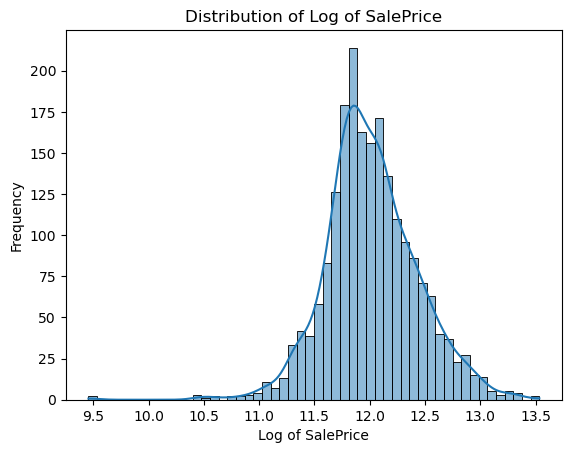

In [9]:
# Distribution of the target variable
sns.histplot(y_train, kde=True) 
plt.title('Distribution of Log of SalePrice')
plt.xlabel('Log of SalePrice')
plt.ylabel('Frequency')
plt.show()

In [19]:
def score_model(X: pd.DataFrame, y: pd.Series, model=XGBRegressor()) -> float:
    # Metric for Housing competition is RMSE (Root Mean Squared Error)
    score = cross_val_score(
        model, X, y, cv=10, scoring="neg_root_mean_squared_error",
    )
    score = -1 * score.mean()
    return score

baseline_score = score_model(X_train, y_train)
print(f"Baseline score: {baseline_score:.5f} RMSE")

Baseline score: 0.14754 RMSE


### Select the optimal span

### Linear regression models
with Lasso / Ridge / Elasticnet penalyu

In [21]:
# Lasso Regression
from sklearn.linear_model import LassoCV
model = LassoCV(alphas=None, cv=5, random_state=seed_val)
model.fit(X_train, y_train)

# verify the model with the test data
y_pred = model.predict(X_test)
print(f"Lasso score: {score_model(X_test, y_test, model):.5f} RMSE")


Lasso score: 0.21557 RMSE


In [22]:
# Ridge Regression
from sklearn.linear_model import RidgeCV

ridge_alphas = np.logspace(-10, 1, 100)
model = RidgeCV(alphas=ridge_alphas, cv=5, scoring='neg_root_mean_squared_error')
model.fit(X_train, y_train)

# verify the model with the test data
y_pred = model.predict(X_test)
print(f"Ridge score: {score_model(X_test, y_test, model):.5f} RMSE")

Ridge score: 0.18559 RMSE


In [24]:
# Elasticnet Regression
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(alphas=None, cv=5, random_state=seed_val)
model.fit(X_train, y_train)

# verify the model with the test data
y_pred = model.predict(X_test)
print(f"Elasticnet score: {score_model(X_test, y_test, model):.5f} RMSE")


Elasticnet score: 0.21558 RMSE


### Tree models
randomForest or boosting tree

In [26]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=seed_val)
model.fit(X_train, y_train)

# verify the model with the test data
y_pred = model.predict(X_test)
print(f"Random Forest score: {score_model(X_test, y_test, model):.5f} RMSE")

Random Forest score: 0.15118 RMSLE


In [27]:
# Boosting Tree
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=seed_val)
model.fit(X_train, y_train)

# verify the model with the test data
y_pred = model.predict(X_test)
print(f"Boosting Tree score: {score_model(X_test, y_test, model):.5f} RMSE")

Boosting Tree score: 0.15130 RMSE
